# Step 1. 실험환경 Set-up

우선 작업에 필요한 라이브러리를 불러온다

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

위 링크에서 자료를 다운 받았다. <br>
데이터는 chest-xray 폴더 아래에 train, val, test 폴더로 구성되어있으며 <br>
각 폴더의 하위 폴더에 정상과 폐렴 사진 폴더가 준비되어있다. 

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
TRAIN_PATH =  './chest_xray/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = './chest_xray/val/*/*'
TEST_PATH = './chest_xray/test/*/*'

# Step 2. 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


일반적으로 train : val : test의 비율은 7:2:1이 적절하므로 train에서 val로 데이터를 조금 양분한다. 

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


tf.data 인스턴스 만들기

In [5]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [6]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


현재 라벨 데이터가 없으므로 폴더 경로명에 따라 라벨을 붙여준다.

In [7]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [8]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [9]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [10]:
for image, label in train_ds.take(10):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  False


라벨이 잘 부여된 것을 확인했으니 이제 test 데이터 셋을 구성한다.

In [11]:
# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 300
EPOCHS = 40

배치 사이즈와 epoch를 조정해서 튜닝한다.

In [12]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


이제 현재 준비된 데이터를 증강시킨다. <br>
data augmentation을 진행한다. <br>
진행하는 data augmentation은 좌우 반전과 상하반전 등을 진행한다.

참고 : https://www.tensorflow.org/api_docs/python/tf/image/random_flip_left_right


In [13]:
from tensorflow.keras import layers

In [17]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    #image = tf.image.random_flip_up_down(image) # 랜덤하게 상하를 반전합니다.
    image = tf.image.random_brightness(image, max_delta=0.2) # 랜덤하게 밝기를 조절합니다.
    image = tf.clip_by_value(image, 0, 1)
  #layers.RandomContrast, layers.RandomCrop, layers.RandomZoom
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds


In [18]:

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

이것으로 데이터 준비를 마친다.

# Step 3. 데이터 시각화

In [ ]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(10,math.ceil(BATCH_SIZE/10),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

잘 바뀐 것을 확인할 수 있다.

# Step 4. CNN 모델링

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

dense_block을 추가해보기도 하고, 레이어의 크기를 바꿔보기도 하고, 배치노멀화나 dropout을 둘 중 하나만 적용해보기도 하고 다양한 시도를 진행하였다.

# Step 5. 데이터 imbalance 처리

train 폴더에서 정상 사진과 폐렴 사진의 비율을 확인한다.

In [20]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
.\chest_xray\train\NORMAL\NORMAL2-IM-0707-0001.jpeg
Pneumonia image path
.\chest_xray\train\PNEUMONIA\person610_bacteria_2475.jpeg


In [21]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


각 라벨별로 가중치 설정도 마무리되었다.

# Step 6. 모델 훈련

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [24]:
es = EarlyStopping(monitor='val_loss', mode = 'min', verbose=1, patience = 5, restore_best_weights = True)

In [25]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [26]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks =[es]
    )

Epoch 1/40
13/13 [==============================] - 33s 3s/step - loss: 0.8140 - accuracy: 0.5354 - precision: 0.7797 - recall: 0.5226 - val_loss: 0.7006 - val_accuracy: 0.2722 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
13/13 [==============================] - 35s 3s/step - loss: 0.6139 - accuracy: 0.6490 - precision: 0.8855 - recall: 0.6072 - val_loss: 0.6978 - val_accuracy: 0.2656 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
13/13 [==============================] - 37s 3s/step - loss: 0.4874 - accuracy: 0.7451 - precision: 0.9351 - recall: 0.7060 - val_loss: 0.6534 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 4/40
13/13 [==============================] - 32s 2s/step - loss: 0.4150 - accuracy: 0.8010 - precision: 0.9567 - recall: 0.7678 - val_loss: 0.6039 - val_accuracy: 0.7400 - val_precision: 0.7400 - val_recall: 1.0000
Epoch 5/40
13/13 [==============================] - 32s 2s/step - loss: 0.3310 - accuracy: 0.842

학습 도중 다양한 요소가 고려되었다.

# Step 7. 결과 확인과 시각화

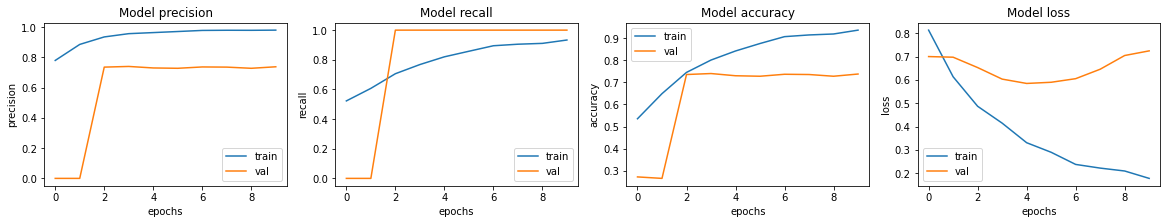

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

3/3 [==============================] - 2s 660ms/step - loss: 0.6749 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6748896837234497,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


# 마무리



가장 잘나온 정확도가 84.6% 였는데, 이게 처음 작업했던 내용이었다.

그런데 문제가 같은 설정으로 돌렸는데 다시 그때의 정확도가 안 나온다...